In [5]:
# Cell 1: Setup project paths
import sys
from pathlib import Path

# Get project root (go up from notebooks/01_data_exploration/ to project root)
project_root = Path.cwd().parent.parent  # Go up 2 levels
print(f"Project root: {project_root}")

# Add project root to Python path
sys.path.insert(0, str(project_root))

# Change working directory to project root
import os
os.chdir(project_root)
print(f"Current working directory: {Path.cwd()}")

Project root: /Users/jamesliu/Documents/GitHub/skyguard
Current working directory: /Users/jamesliu/Documents/GitHub/skyguard


🚀 STARTING VISDRONE DATA EXPLORATION
🔍 VisDrone Explorer initialized
📁 Data root: /Users/jamesliu/Documents/GitHub/skyguard/data/raw/vision/visdrone

🔍 VALIDATING DATASET STRUCTURE
✅ VisDrone2019-DET-train/images: 6471 images
✅ VisDrone2019-DET-train/annotations: 6471 annotation files
✅ VisDrone2019-DET-val/images: 548 images
✅ VisDrone2019-DET-val/annotations: 548 annotation files
✅ VisDrone2019-DET-test-dev/images: 1610 images
✅ VisDrone2019-DET-test-dev/annotations: 1610 annotation files

🎉 Dataset structure is VALID!

📊 ANALYZING TRAIN SPLIT
📸 Total images: 6471
📝 Total annotation files: 6471
Processing image 1/1000
Processing image 101/1000
Processing image 201/1000
Processing image 301/1000
Processing image 401/1000
Processing image 501/1000
Processing image 601/1000
Processing image 701/1000
Processing image 801/1000
Processing image 901/1000

📈 SUMMARY:
   • Images with objects: 1000/1000 (100.0%)
   • Average objects per image: 52.2
   • Most common classes:
     - car: 22191 

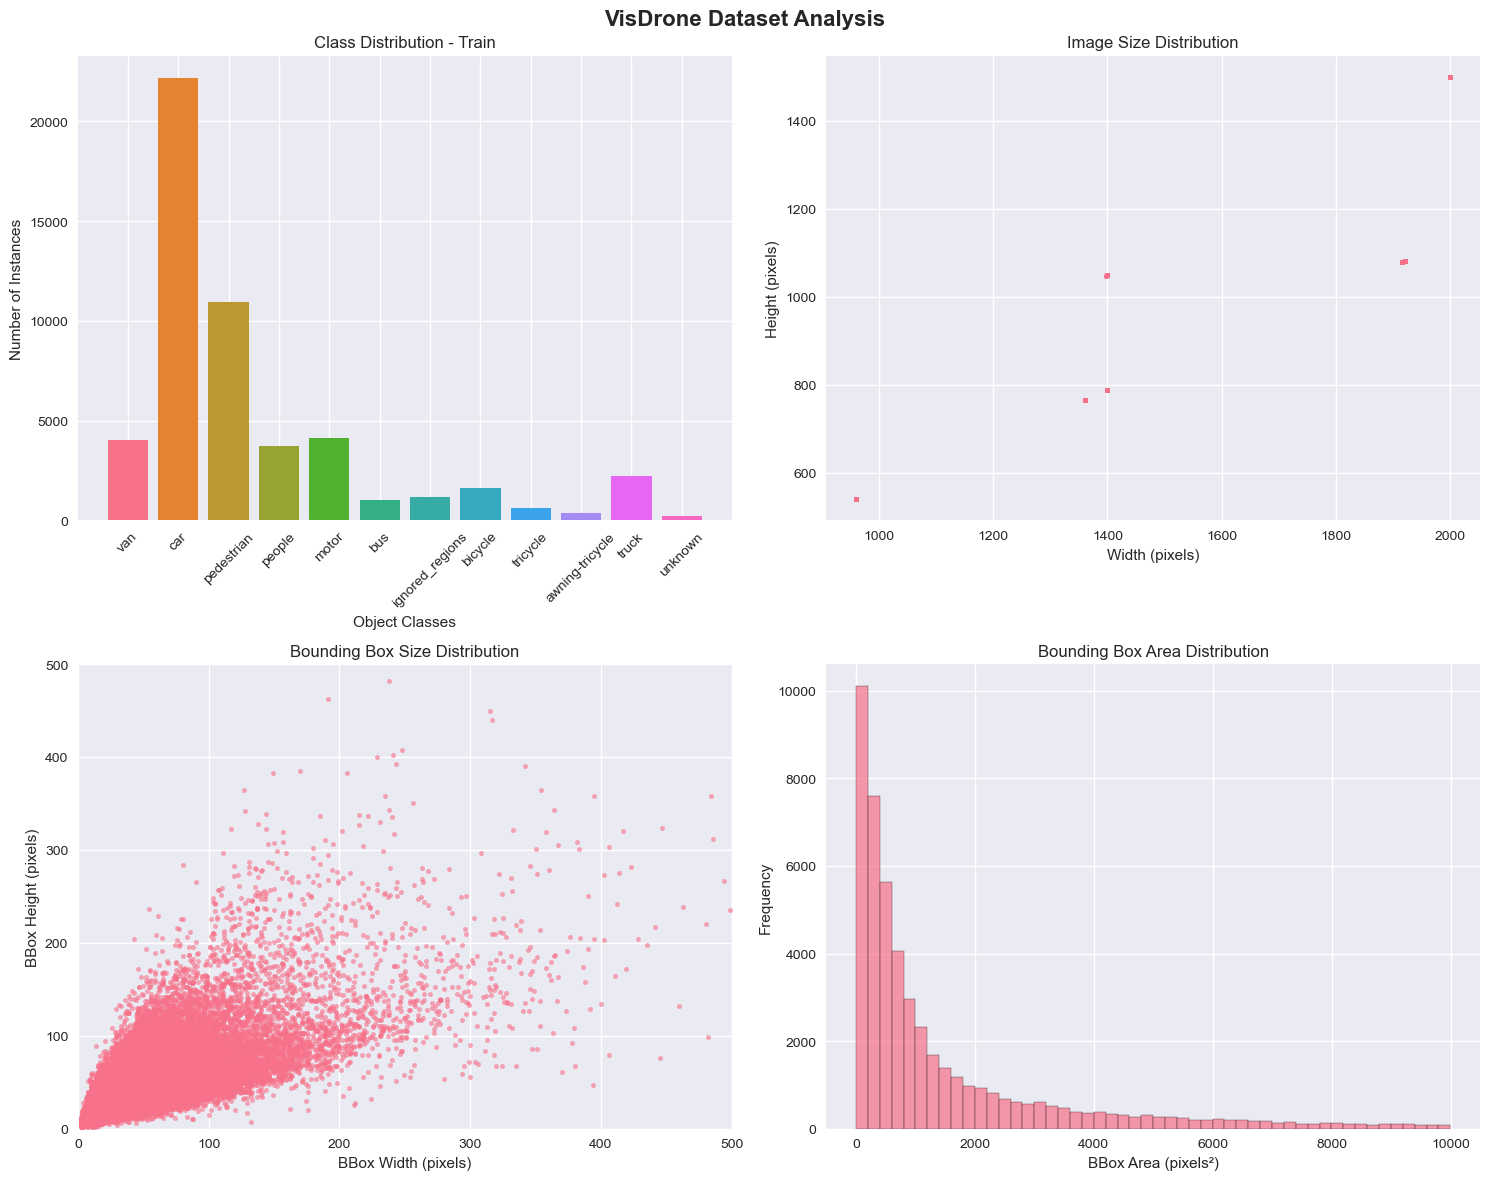


📊 DETAILED STATISTICS for TRAIN:
Image Dimensions:
  • Width  - Mean: 1511, Std: 268
  • Height - Mean: 997, Std: 241
Bounding Box Areas:
  • Mean: 2725 pixels²
  • Median: 731 pixels²
  • Std: 7246 pixels²

📊 ANALYZING VAL SPLIT
📸 Total images: 548
📝 Total annotation files: 548
Processing image 1/548
Processing image 101/548
Processing image 201/548
Processing image 301/548
Processing image 401/548
Processing image 501/548

📈 SUMMARY:
   • Images with objects: 548/548 (100.0%)
   • Average objects per image: 73.3
   • Most common classes:
     - car: 14064 (35.0%)
     - pedestrian: 8844 (22.0%)
     - people: 5125 (12.8%)
     - motor: 4886 (12.2%)
     - van: 1975 (4.9%)


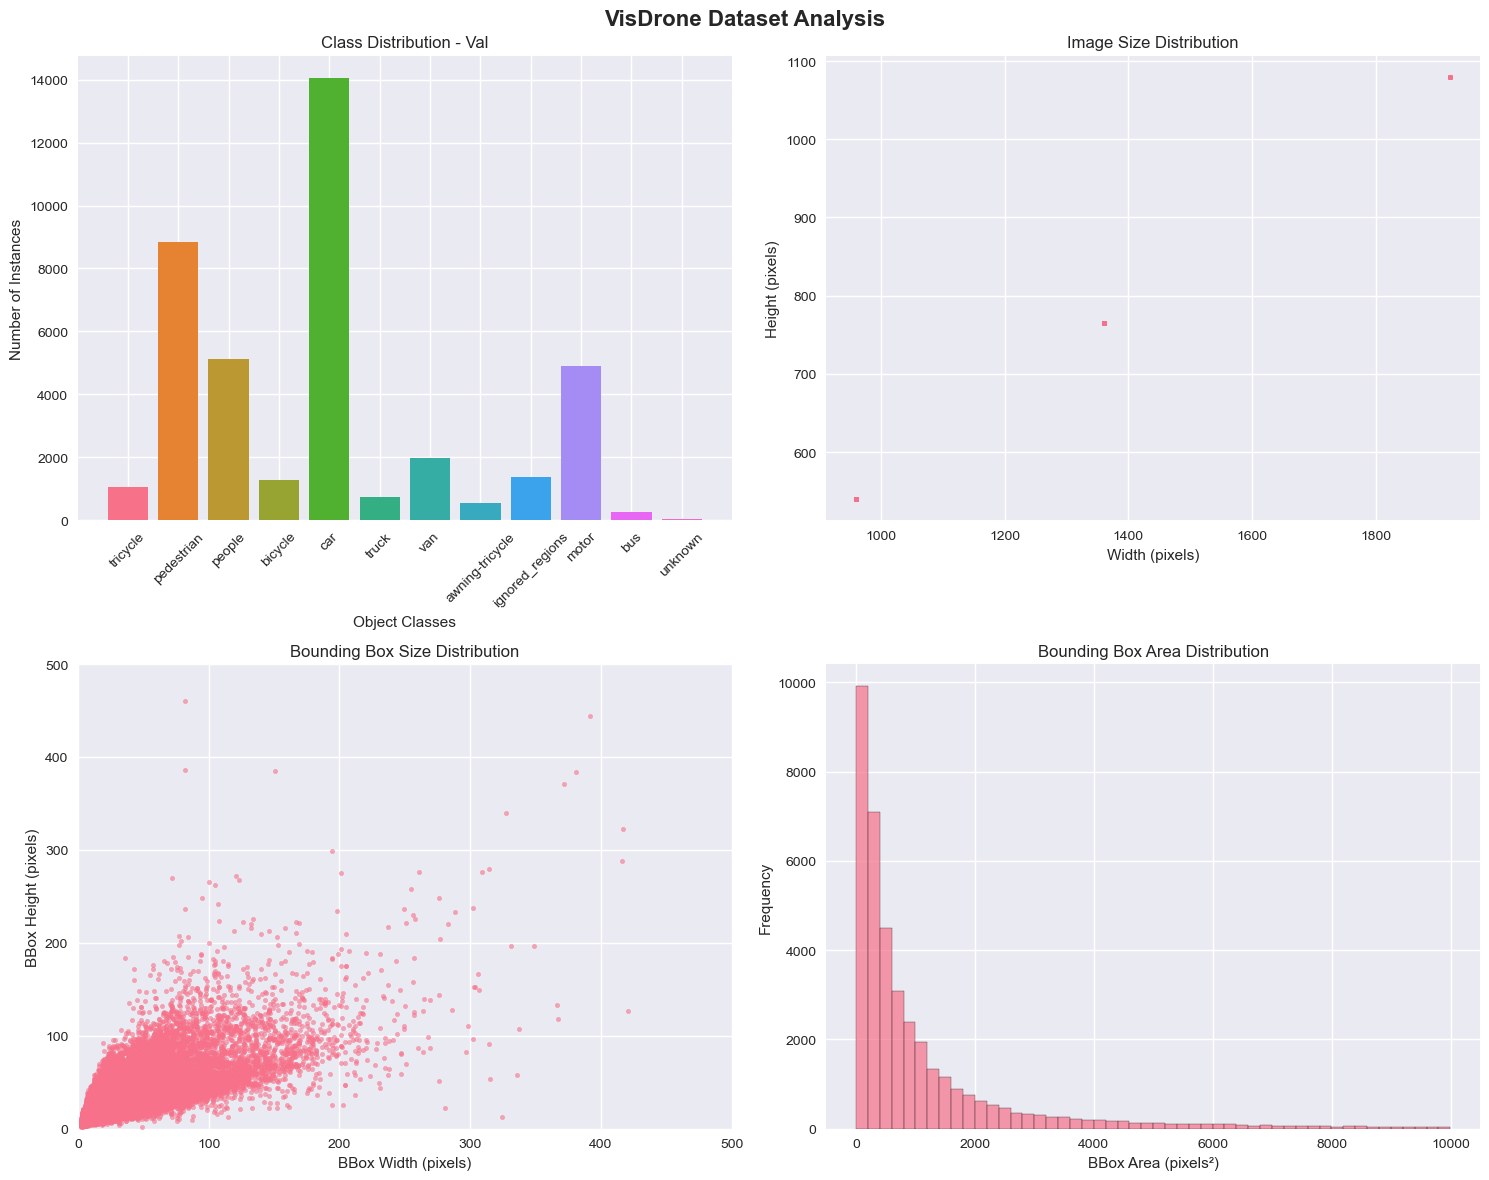


📊 DETAILED STATISTICS for VAL:
Image Dimensions:
  • Width  - Mean: 1291, Std: 204
  • Height - Mean: 726, Std: 115
Bounding Box Areas:
  • Mean: 1592 pixels²
  • Median: 532 pixels²
  • Std: 4642 pixels²

📊 ANALYZING TEST-DEV SPLIT
📸 Total images: 1610
📝 Total annotation files: 1610
Processing image 1/1000
Processing image 101/1000
Processing image 201/1000
Processing image 301/1000
Processing image 401/1000
Processing image 501/1000
Processing image 601/1000
Processing image 701/1000
Processing image 801/1000
Processing image 901/1000

📈 SUMMARY:
   • Images with objects: 1000/1000 (100.0%)
   • Average objects per image: 47.7
   • Most common classes:
     - car: 17275 (36.2%)
     - pedestrian: 13093 (27.5%)
     - people: 3909 (8.2%)
     - motor: 3543 (7.4%)
     - van: 3309 (6.9%)


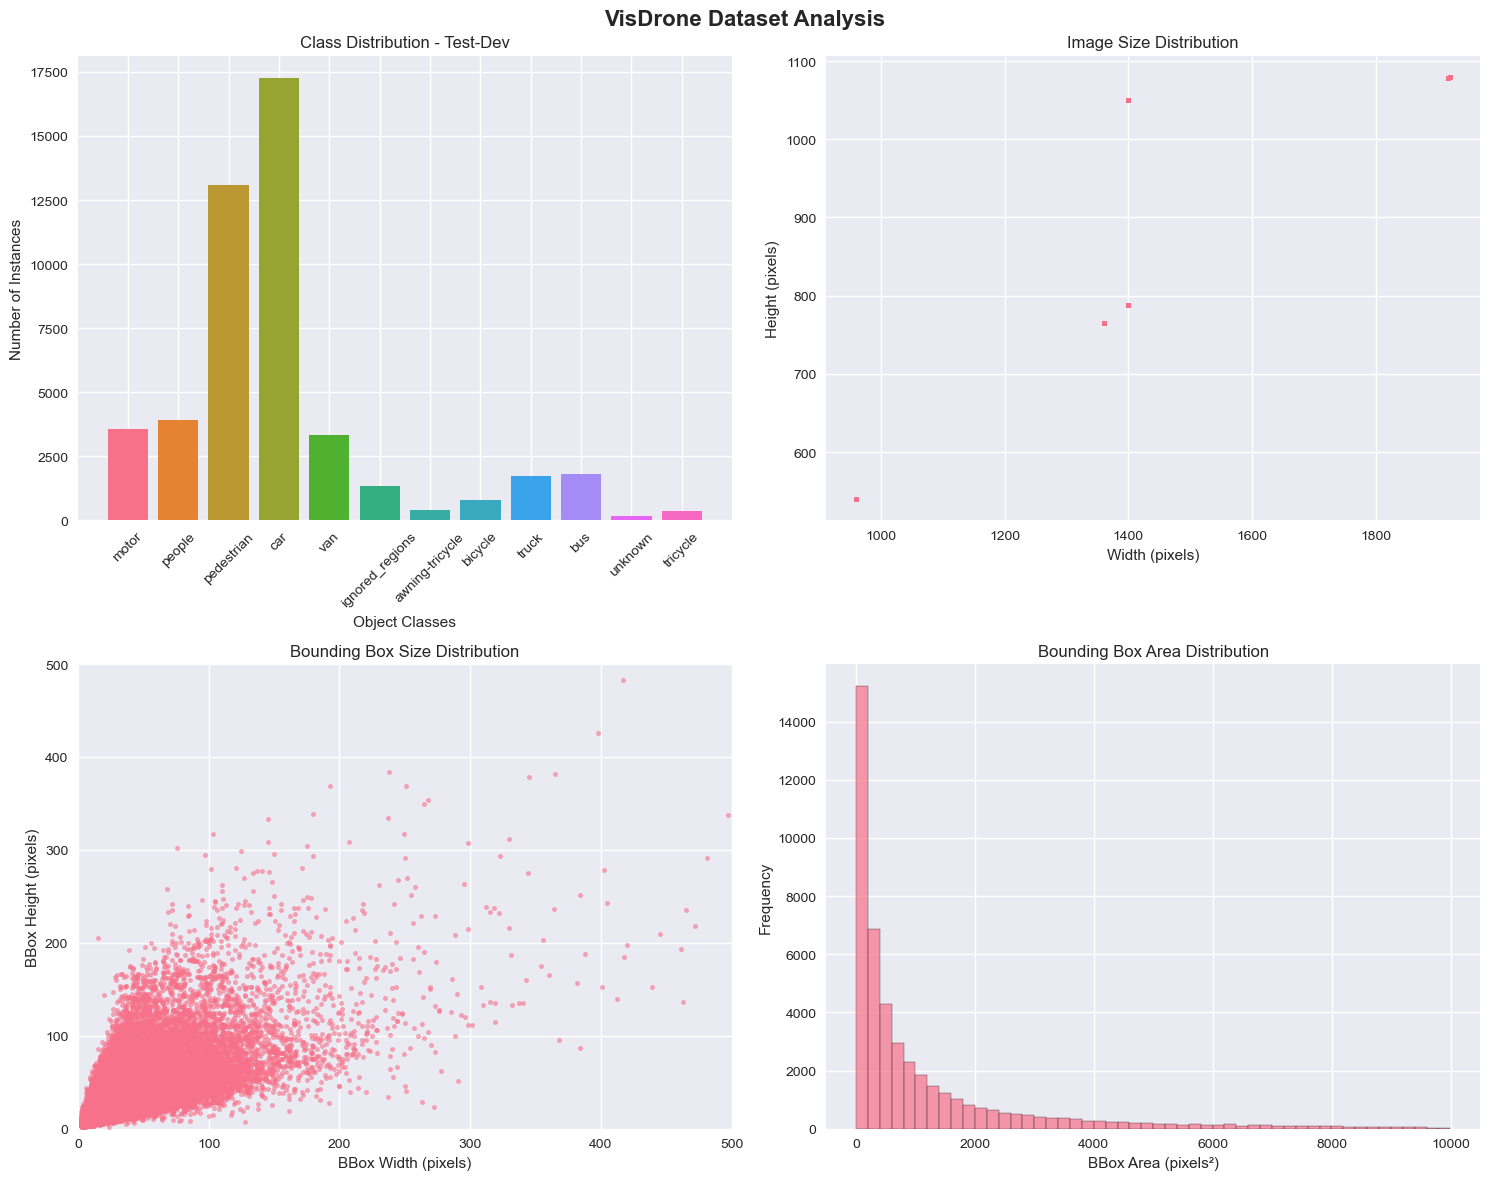


📊 DETAILED STATISTICS for TEST-DEV:
Image Dimensions:
  • Width  - Mean: 1445, Std: 187
  • Height - Mean: 859, Std: 136
Bounding Box Areas:
  • Mean: 1788 pixels²
  • Median: 480 pixels²
  • Std: 5188 pixels²

🖼️ VISUALIZING SAMPLE IMAGES from TRAIN


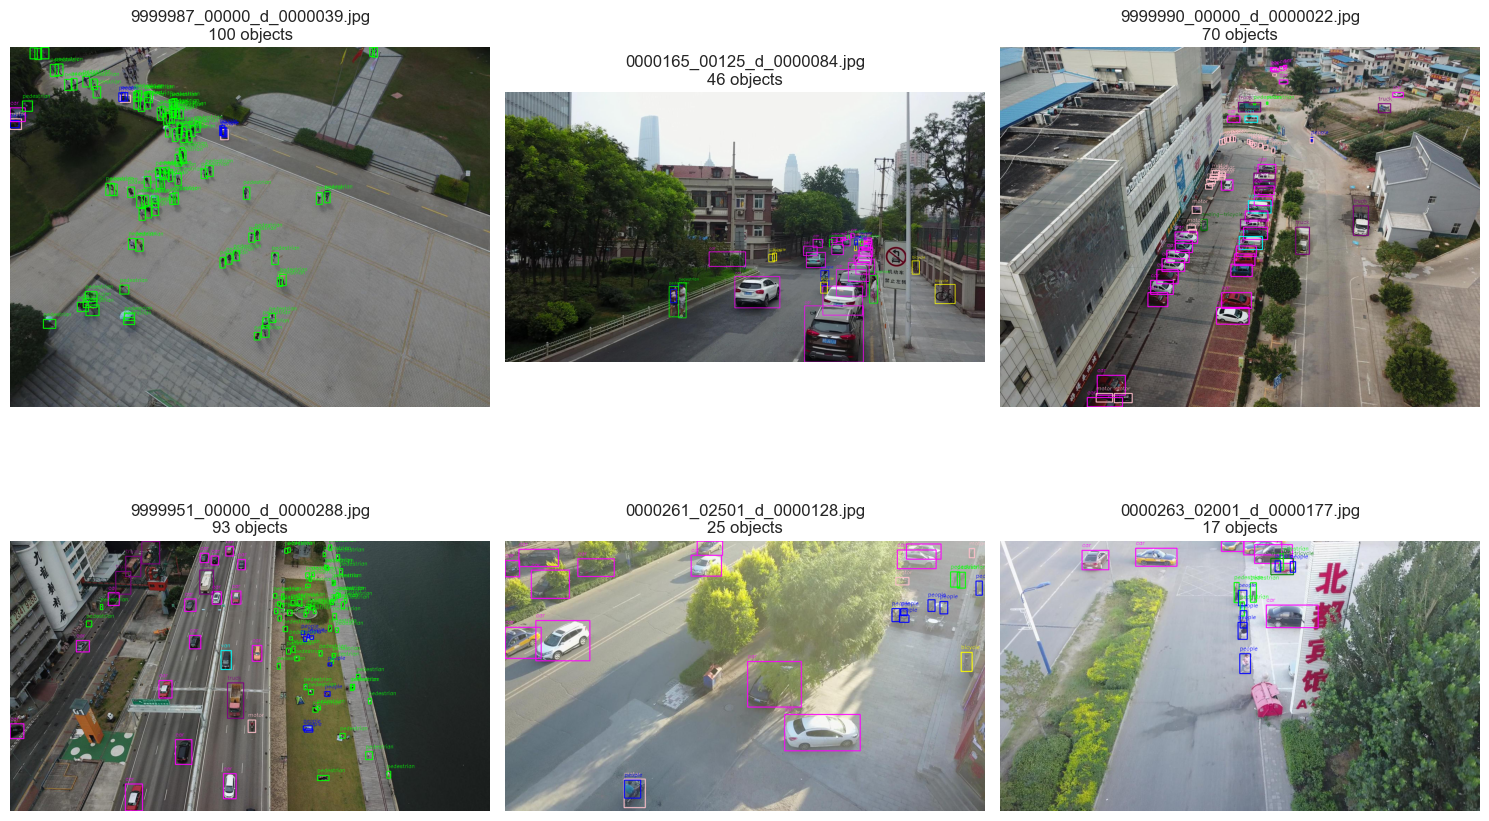


🔄 YOLO FORMAT CONVERSION GUIDE
VisDrone Format (current):
  • <bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>
  • Absolute pixel coordinates
  • 11 classes (0-10, where 0 is 'ignored')

YOLO Format (needed for training):
  • <class_id> <center_x> <center_y> <width> <height>
  • Normalized coordinates (0.0 to 1.0)
  • Class IDs start from 0

Conversion steps needed:
  1. Filter out 'ignored' regions (class 0)
  2. Remap class IDs: 1-10 → 0-9
  3. Convert bbox format: (left,top,w,h) → (center_x,center_y,w,h)
  4. Normalize coordinates by image dimensions

📝 Next steps:
  • Run the data conversion script
  • Create train.txt, val.txt, test.txt file lists
  • Generate classes.txt with class names
  • Create YOLO dataset configuration file

🎉 EXPLORATION COMPLETE!
✅ Your VisDrone dataset is ready for processing
🔄 Next: Run the data conversion script to create YOLO format


In [6]:
# VisDrone Data Exploration and Validation
# File: notebooks/01_data_exploration/vision_data_analysis.ipynb

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import json
from collections import Counter, defaultdict

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class VisDroneExplorer:
    """
    Complete VisDrone dataset explorer and validator
    
    This class helps you understand your VisDrone dataset structure,
    validate the data, and visualize key statistics before training.
    """
    
    def __init__(self, data_root=None):
        """
        Initialize the VisDrone explorer
        
        Args:
            data_root (str): Path to VisDrone data directory (relative to project root)
        """
        # Get project root directory (where this script is run from)
        if data_root is None:
            # Default path relative to project root
            data_root = "data/raw/vision/visdrone"
        
        # Make path relative to current working directory (project root)
        self.data_root = Path(data_root).resolve()
        """
        Initialize the VisDrone explorer
        
        Args:
            data_root (str): Path to VisDrone data directory
        """
        self.data_root = Path(data_root)
        
        # VisDrone class mapping (10 classes total)
        self.class_names = {
            0: 'ignored_regions',
            1: 'pedestrian', 
            2: 'people',
            3: 'bicycle',
            4: 'car',
            5: 'van',
            6: 'truck', 
            7: 'tricycle',
            8: 'awning-tricycle',
            9: 'bus',
            10: 'motor'
        }
        
        # Colors for visualization
        self.colors = [
            (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
            (255, 0, 255), (0, 255, 255), (128, 0, 128), (255, 165, 0),
            (0, 128, 0), (128, 128, 128), (255, 192, 203)
        ]
        
        print(f"🔍 VisDrone Explorer initialized")
        print(f"📁 Data root: {self.data_root.absolute()}")
    
    def validate_dataset_structure(self):
        """
        Validate that the VisDrone dataset has correct structure
        
        Returns:
            bool: True if structure is valid
        """
        print("\n🔍 VALIDATING DATASET STRUCTURE")
        print("=" * 50)
        
        required_dirs = [
            "VisDrone2019-DET-train",
            "VisDrone2019-DET-val", 
            "VisDrone2019-DET-test-dev"
        ]
        
        all_valid = True
        
        for dir_name in required_dirs:
            dir_path = self.data_root / dir_name
            
            if not dir_path.exists():
                print(f"❌ Missing directory: {dir_name}")
                all_valid = False
                continue
                
            # Check for required subdirectories
            images_dir = dir_path / "images"
            annotations_dir = dir_path / "annotations"
            
            if not images_dir.exists():
                print(f"❌ Missing images directory in {dir_name}")
                all_valid = False
            else:
                image_count = len(list(images_dir.glob("*.jpg")))
                print(f"✅ {dir_name}/images: {image_count} images")
            
            if not annotations_dir.exists():
                print(f"❌ Missing annotations directory in {dir_name}")
                all_valid = False
            else:
                annotation_count = len(list(annotations_dir.glob("*.txt")))
                print(f"✅ {dir_name}/annotations: {annotation_count} annotation files")
        
        if all_valid:
            print(f"\n🎉 Dataset structure is VALID!")
        else:
            print(f"\n💥 Dataset structure has ERRORS - please fix before proceeding")
            
        return all_valid
    
    def load_annotation(self, annotation_path):
        """
        Load and parse a VisDrone annotation file
        
        VisDrone annotation format:
        <bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>
        
        Args:
            annotation_path (Path): Path to annotation file
            
        Returns:
            list: List of annotation dictionaries
        """
        annotations = []
        
        if not annotation_path.exists():
            return annotations
            
        with open(annotation_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:  # Skip empty lines
                    continue
                    
                parts = line.split(',')
                if len(parts) >= 6:  # Minimum required fields
                    annotation = {
                        'bbox_left': int(parts[0]),
                        'bbox_top': int(parts[1]), 
                        'bbox_width': int(parts[2]),
                        'bbox_height': int(parts[3]),
                        'score': float(parts[4]) if parts[4] != '' else 1.0,
                        'object_category': int(parts[5]),
                        'truncation': int(parts[6]) if len(parts) > 6 and parts[6] != '' else 0,
                        'occlusion': int(parts[7]) if len(parts) > 7 and parts[7] != '' else 0
                    }
                    
                    # Calculate additional properties
                    annotation['bbox_right'] = annotation['bbox_left'] + annotation['bbox_width']
                    annotation['bbox_bottom'] = annotation['bbox_top'] + annotation['bbox_height']
                    annotation['bbox_area'] = annotation['bbox_width'] * annotation['bbox_height']
                    annotation['class_name'] = self.class_names.get(annotation['object_category'], 'unknown')
                    
                    annotations.append(annotation)
        
        return annotations
    
    def analyze_dataset_split(self, split_name):
        """
        Analyze a single dataset split (train/val/test-dev)
        
        Args:
            split_name (str): Name of the split to analyze
            
        Returns:
            dict: Analysis results
        """
        print(f"\n📊 ANALYZING {split_name.upper()} SPLIT")
        print("=" * 50)
        
        split_dir = self.data_root / f"VisDrone2019-DET-{split_name}"
        images_dir = split_dir / "images"
        annotations_dir = split_dir / "annotations"
        
        if not split_dir.exists():
            print(f"❌ Split directory not found: {split_dir}")
            return {}
        
        # Get all image files
        image_files = list(images_dir.glob("*.jpg"))
        annotation_files = list(annotations_dir.glob("*.txt"))
        
        print(f"📸 Total images: {len(image_files)}")
        print(f"📝 Total annotation files: {len(annotation_files)}")
        
        # Initialize counters
        class_counts = Counter()
        image_sizes = []
        bbox_sizes = []
        bbox_areas = []
        images_with_objects = 0
        total_objects = 0
        
        # Process each image and its annotations
        for i, img_path in enumerate(image_files[:1000]):  # Limit to first 1000 for speed
            if i % 100 == 0:
                print(f"Processing image {i+1}/{min(1000, len(image_files))}")
            
            # Load image to get dimensions
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    image_sizes.append((width, height))
            except Exception as e:
                print(f"⚠️ Could not load image {img_path}: {e}")
                continue
            
            # Load corresponding annotation
            annotation_path = annotations_dir / f"{img_path.stem}.txt"
            annotations = self.load_annotation(annotation_path)
            
            if annotations:
                images_with_objects += 1
                total_objects += len(annotations)
                
                for ann in annotations:
                    class_counts[ann['class_name']] += 1
                    bbox_sizes.append((ann['bbox_width'], ann['bbox_height']))
                    bbox_areas.append(ann['bbox_area'])
        
        # Calculate statistics
        analyzed_images = min(1000, len(image_files))
        
        results = {
            'split_name': split_name,
            'total_images': len(image_files),
            'analyzed_images': analyzed_images,
            'total_annotation_files': len(annotation_files),
            'images_with_objects': images_with_objects,
            'total_objects': total_objects,
            'avg_objects_per_image': total_objects / analyzed_images if analyzed_images > 0 else 0,
            'class_counts': dict(class_counts),
            'image_sizes': image_sizes,
            'bbox_sizes': bbox_sizes,
            'bbox_areas': bbox_areas
        }
        
        # Print summary
        print(f"\n📈 SUMMARY:")
        print(f"   • Images with objects: {images_with_objects}/{analyzed_images} ({images_with_objects/analyzed_images*100:.1f}%)")
        print(f"   • Average objects per image: {results['avg_objects_per_image']:.1f}")
        print(f"   • Most common classes:")
        
        for class_name, count in class_counts.most_common(5):
            percentage = count / total_objects * 100 if total_objects > 0 else 0
            print(f"     - {class_name}: {count} ({percentage:.1f}%)")
        
        return results
    
    def visualize_class_distribution(self, analysis_results):
        """
        Create visualizations for class distribution across splits
        
        Args:
            analysis_results (dict): Results from analyze_dataset_split
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('VisDrone Dataset Analysis', fontsize=16, fontweight='bold')
        
        # 1. Class distribution
        if analysis_results['class_counts']:
            classes = list(analysis_results['class_counts'].keys())
            counts = list(analysis_results['class_counts'].values())
            
            axes[0, 0].bar(classes, counts, color=sns.color_palette("husl", len(classes)))
            axes[0, 0].set_title(f'Class Distribution - {analysis_results["split_name"].title()}')
            axes[0, 0].set_xlabel('Object Classes')
            axes[0, 0].set_ylabel('Number of Instances')
            axes[0, 0].tick_params(axis='x', rotation=45)
        
        # 2. Image size distribution
        if analysis_results['image_sizes']:
            widths, heights = zip(*analysis_results['image_sizes'])
            axes[0, 1].scatter(widths, heights, alpha=0.6, s=10)
            axes[0, 1].set_title('Image Size Distribution')
            axes[0, 1].set_xlabel('Width (pixels)')
            axes[0, 1].set_ylabel('Height (pixels)')
        
        # 3. Bounding box size distribution
        if analysis_results['bbox_sizes']:
            bbox_widths, bbox_heights = zip(*analysis_results['bbox_sizes'])
            axes[1, 0].scatter(bbox_widths, bbox_heights, alpha=0.6, s=10)
            axes[1, 0].set_title('Bounding Box Size Distribution')
            axes[1, 0].set_xlabel('BBox Width (pixels)')
            axes[1, 0].set_ylabel('BBox Height (pixels)')
            axes[1, 0].set_xlim(0, 500)  # Focus on smaller objects
            axes[1, 0].set_ylim(0, 500)
        
        # 4. Bounding box area histogram
        if analysis_results['bbox_areas']:
            # Filter out very large boxes for better visualization
            filtered_areas = [area for area in analysis_results['bbox_areas'] if area < 10000]
            axes[1, 1].hist(filtered_areas, bins=50, alpha=0.7, edgecolor='black')
            axes[1, 1].set_title('Bounding Box Area Distribution')
            axes[1, 1].set_xlabel('BBox Area (pixels²)')
            axes[1, 1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed statistics
        print(f"\n📊 DETAILED STATISTICS for {analysis_results['split_name'].upper()}:")
        print("=" * 60)
        
        if analysis_results['image_sizes']:
            widths, heights = zip(*analysis_results['image_sizes'])
            print(f"Image Dimensions:")
            print(f"  • Width  - Mean: {np.mean(widths):.0f}, Std: {np.std(widths):.0f}")
            print(f"  • Height - Mean: {np.mean(heights):.0f}, Std: {np.std(heights):.0f}")
        
        if analysis_results['bbox_areas']:
            print(f"Bounding Box Areas:")
            print(f"  • Mean: {np.mean(analysis_results['bbox_areas']):.0f} pixels²")
            print(f"  • Median: {np.median(analysis_results['bbox_areas']):.0f} pixels²")
            print(f"  • Std: {np.std(analysis_results['bbox_areas']):.0f} pixels²")
    
    def visualize_sample_images(self, split_name="train", num_samples=6):
        """
        Visualize sample images with annotations
        
        Args:
            split_name (str): Dataset split to sample from
            num_samples (int): Number of sample images to show
        """
        print(f"\n🖼️ VISUALIZING SAMPLE IMAGES from {split_name.upper()}")
        print("=" * 50)
        
        split_dir = self.data_root / f"VisDrone2019-DET-{split_name}"
        images_dir = split_dir / "images"
        annotations_dir = split_dir / "annotations"
        
        # Get sample image files
        image_files = list(images_dir.glob("*.jpg"))
        sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
        
        # Create subplot grid
        cols = 3
        rows = (num_samples + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, img_path in enumerate(sample_files):
            row, col = idx // cols, idx % cols
            
            # Load image
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Load annotations
            annotation_path = annotations_dir / f"{img_path.stem}.txt"
            annotations = self.load_annotation(annotation_path)
            
            # Draw bounding boxes
            for ann in annotations:
                if ann['object_category'] != 0:  # Skip ignored regions
                    x1, y1 = ann['bbox_left'], ann['bbox_top']
                    x2, y2 = ann['bbox_right'], ann['bbox_bottom']
                    
                    # Get color for this class
                    color = self.colors[ann['object_category'] % len(self.colors)]
                    
                    # Draw rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    
                    # Add class label
                    label = ann['class_name']
                    cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 
                               0.5, color, 1)
            
            # Display image
            axes[row, col].imshow(img)
            axes[row, col].set_title(f"{img_path.name}\n{len(annotations)} objects")
            axes[row, col].axis('off')
        
        # Hide empty subplots
        for idx in range(num_samples, rows * cols):
            row, col = idx // cols, idx % cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def create_yolo_format_summary(self):
        """
        Create a summary of how to convert VisDrone to YOLO format
        """
        print(f"\n🔄 YOLO FORMAT CONVERSION GUIDE")
        print("=" * 50)
        
        print("VisDrone Format (current):")
        print("  • <bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>")
        print("  • Absolute pixel coordinates")
        print("  • 11 classes (0-10, where 0 is 'ignored')")
        
        print("\nYOLO Format (needed for training):")
        print("  • <class_id> <center_x> <center_y> <width> <height>")
        print("  • Normalized coordinates (0.0 to 1.0)")
        print("  • Class IDs start from 0")
        
        print("\nConversion steps needed:")
        print("  1. Filter out 'ignored' regions (class 0)")
        print("  2. Remap class IDs: 1-10 → 0-9")
        print("  3. Convert bbox format: (left,top,w,h) → (center_x,center_y,w,h)")
        print("  4. Normalize coordinates by image dimensions")
        
        print("\n📝 Next steps:")
        print("  • Run the data conversion script")
        print("  • Create train.txt, val.txt, test.txt file lists")
        print("  • Generate classes.txt with class names")
        print("  • Create YOLO dataset configuration file")

def main():
    """
    Main function to run complete VisDrone exploration
    """
    print("🚀 STARTING VISDRONE DATA EXPLORATION")
    print("=" * 60)
    
    # Initialize explorer with explicit path from project root
    explorer = VisDroneExplorer(data_root="data/raw/vision/visdrone")
    
    # Step 1: Validate dataset structure
    if not explorer.validate_dataset_structure():
        print("❌ Dataset validation failed. Please check your data placement.")
        return
    
    # Step 2: Analyze each split
    results = {}
    for split in ['train', 'val', 'test-dev']:
        results[split] = explorer.analyze_dataset_split(split)
        
        # Visualize this split
        if results[split]:
            explorer.visualize_class_distribution(results[split])
    
    # Step 3: Show sample images
    explorer.visualize_sample_images('train', num_samples=6)
    
    # Step 4: YOLO conversion guide
    explorer.create_yolo_format_summary()
    
    print(f"\n🎉 EXPLORATION COMPLETE!")
    print("✅ Your VisDrone dataset is ready for processing")
    print("🔄 Next: Run the data conversion script to create YOLO format")

if __name__ == "__main__":
    main()